In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

import numpy as np
import pandas as pd
import torch
import tensorflow as tf
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM, Bidirectional, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, average_precision_score,
                           accuracy_score, precision_score, recall_score, f1_score)
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

def load_peptide_data(data_path, max_sequences_per_class=20000):
    therapeutic_path = os.path.join(data_path, "Therapeutic data")
    non_therapeutic_path = os.path.join(data_path, "Non-Therapeutic data")
    sequences, labels = [], []
    file_stats = {}
    if not os.path.exists(therapeutic_path):
        print(f"Warning: {therapeutic_path} not found!")
        return [], [], {}
    if not os.path.exists(non_therapeutic_path):
        print(f"Warning: {non_therapeutic_path} not found!")
        return [], [], {}
    print("Loading therapeutic peptides for binary classification...")
    therapeutic_total = 0
    therapeutic_files = [f for f in os.listdir(therapeutic_path) if f.endswith('.csv')]
    for filename in therapeutic_files:
        file_path = os.path.join(therapeutic_path, filename)
        try:
            df = pd.read_csv(file_path)
            if df.shape[1] >= 1:
                seqs = df.iloc[:, 0].dropna().astype(str).tolist()
                seqs = [seq.strip().upper() for seq in seqs if seq.strip()]
                valid_seqs = []
                for seq in seqs:
                    clean_seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])
                    if 5 <= len(clean_seq) <= 200:
                        valid_seqs.append(clean_seq)
                if max_sequences_per_class and therapeutic_total + len(valid_seqs) > max_sequences_per_class:
                    remaining = max(0, max_sequences_per_class - therapeutic_total)
                    valid_seqs = valid_seqs[:remaining]
                sequences.extend(valid_seqs)
                labels.extend([1] * len(valid_seqs))
                therapeutic_total += len(valid_seqs)
                file_stats[f"therapeutic_{filename}"] = len(valid_seqs)
                print(f"  ✓ {filename}: {len(valid_seqs)} valid sequences")
                if max_sequences_per_class and therapeutic_total >= max_sequences_per_class:
                    break
        except Exception as e:
            print(f"  ✗ Error reading {filename}: {e}")
            continue
    print(f"Total therapeutic sequences: {therapeutic_total}")
    print("\nLoading non-therapeutic peptides for binary classification...")
    non_therapeutic_total = 0
    non_therapeutic_files = [f for f in os.listdir(non_therapeutic_path) if f.endswith('.csv')]
    for filename in non_therapeutic_files:
        file_path = os.path.join(non_therapeutic_path, filename)
        try:
            df = pd.read_csv(file_path)
            if df.shape[1] >= 1:
                seqs = df.iloc[:, 0].dropna().astype(str).tolist()
                seqs = [seq.strip().upper() for seq in seqs if seq.strip()]
                valid_seqs = []
                for seq in seqs:
                    clean_seq = ''.join([c for c in seq if c in 'ACDEFGHIKLMNPQRSTVWY'])
                    if 5 <= len(clean_seq) <= 200:
                        valid_seqs.append(clean_seq)
                if max_sequences_per_class and non_therapeutic_total + len(valid_seqs) > therapeutic_total:
                    remaining = max(0, therapeutic_total - non_therapeutic_total)
                    valid_seqs = valid_seqs[:remaining]
                sequences.extend(valid_seqs)
                labels.extend([0] * len(valid_seqs))
                non_therapeutic_total += len(valid_seqs)
                file_stats[f"non_therapeutic_{filename}"] = len(valid_seqs)
                print(f"  ✓ {filename}: {len(valid_seqs)} valid sequences")
                if non_therapeutic_total >= therapeutic_total:
                    break
        except Exception as e:
            print(f"  ✗ Error reading {filename}: {e}")
            continue
    print(f"Total non-therapeutic sequences: {non_therapeutic_total}")
    print(f"Overall total: {len(sequences)} sequences")
    print(f"Dataset balance: {sum(labels)/len(labels)*100:.1f}% therapeutic")
    return sequences, labels, file_stats

def create_advanced_binary_classifier(input_dim):
    input_layer = Input(shape=(input_dim,), name='feature_input')
    x = Dense(512, activation='relu', name='dense_1')(input_layer)
    x = BatchNormalization(name='bn_1')(x)
    x = Dropout(0.4, name='dropout_1')(x)
    x = Dense(256, activation='relu', name='dense_2')(x)
    x = BatchNormalization(name='bn_2')(x)
    x = Dropout(0.3, name='dropout_2')(x)
    x = Dense(128, activation='relu', name='dense_3')(x)
    x = BatchNormalization(name='bn_3')(x)
    x = Dropout(0.3, name='dropout_3')(x)
    x = Dense(64, activation='relu', name='dense_4')(x)
    x = BatchNormalization(name='bn_4')(x)
    x = Dropout(0.2, name='dropout_4')(x)
    output = Dense(1, activation='sigmoid', name='therapeutic_prediction')(x)
    model = Model(inputs=input_layer, outputs=output, name='BinaryTherapeuticClassifier')
    model.compile(
        optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )
    return model

def create_ensemble_voting_classifier(X_train, y_train):
    rf_classifier = RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        random_state=42, 
        n_jobs=-1
    )
    gb_classifier = GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )
    svc_classifier = CalibratedClassifierCV(
        SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
        cv=3
    )
    lr_classifier = LogisticRegression(
        C=1.0, 
        max_iter=1000, 
        random_state=42
    )
    voting_classifier = VotingClassifier(
        estimators=[
            ('random_forest', rf_classifier),
            ('gradient_boosting', gb_classifier),
            ('svm', svc_classifier),
            ('logistic_regression', lr_classifier)
        ],
        voting='soft'
    )
    return voting_classifier

def extract_comprehensive_binary_features(sequences):
    features = []
    print("Extracting binary classification optimized features...")
    for seq in tqdm(sequences, desc="Processing sequences"):
        seq_len = len(seq)
        feature_vector = []
        feature_vector.append(seq_len)
        aa_composition = {}
        for aa in 'ACDEFGHIKLMNPQRSTVWY':
            aa_composition[aa] = seq.count(aa) / seq_len
            feature_vector.append(aa_composition[aa])
        cationic = (seq.count('K') + seq.count('R') + seq.count('H')) / seq_len
        hydrophobic = sum(seq.count(aa) for aa in 'AILMFWV') / seq_len
        aromatic = sum(seq.count(aa) for aa in 'FWY') / seq_len
        positive_charge = seq.count('K') + seq.count('R') + seq.count('H')
        negative_charge = seq.count('D') + seq.count('E')
        net_charge = positive_charge - negative_charge
        feature_vector.extend([
            cationic, hydrophobic, aromatic,
            positive_charge / seq_len,
            negative_charge / seq_len,
            net_charge / seq_len,
            abs(net_charge) / seq_len
        ])
        therapeutic_dipeptides = ['KL', 'LK', 'RW', 'WR', 'FK', 'KF', 'LL', 'KK', 'RR']
        for dp in therapeutic_dipeptides:
            count = 0
            for i in range(len(seq) - 1):
                if seq[i:i+2] == dp:
                    count += 1
            feature_vector.append(count / (seq_len - 1) if seq_len > 1 else 0)
        proline_content = seq.count('P') / seq_len
        glycine_content = seq.count('G') / seq_len
        cysteine_content = seq.count('C') / seq_len
        feature_vector.extend([proline_content, glycine_content, cysteine_content])
        hydrophobic_values = {
            'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
            'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
            'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
            'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
        }
        hydrophobic_moment = 0
        for i, aa in enumerate(seq):
            if aa in hydrophobic_values:
                angle = i * 100 * np.pi / 180
                hydrophobic_moment += hydrophobic_values[aa] * np.exp(1j * angle)
        feature_vector.append(abs(hydrophobic_moment) / seq_len)
        features.append(feature_vector)
    features_array = np.array(features, dtype=np.float32)
    print(f"Binary classification features extracted: {features_array.shape[1]} features per sequence")
    return features_array

Using device: cuda
TensorFlow version: 2.10.0
GPU Available: True


In [2]:
print("=== ADVANCED BINARY CLASSIFICATION FOR THERAPEUTIC PEPTIDES ===\n")

# Create necessary directories
os.makedirs("../backend/models", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)

# Load data with correct relative paths
data_path = "../data"
sequences, labels, file_stats = load_peptide_data(data_path, max_sequences_per_class=15000)

# Display dataset statistics
if file_stats:
    print("\n📊 Dataset Statistics by File:")
    for file_key, count in file_stats.items():
        print(f"  {file_key}: {count:,} sequences")

print(f"\nFinal binary classification dataset:")
print(f"Total sequences: {len(sequences):,}")
print(f"Therapeutic peptides: {sum(labels):,} ({sum(labels)/len(labels)*100:.1f}%)")
print(f"Non-therapeutic peptides: {len(labels) - sum(labels):,} ({(len(labels) - sum(labels))/len(labels)*100:.1f}%)")

if len(sequences) == 0:
    print("ERROR: No valid sequences found!")
    print("Please check your data files in ../data/Therapeutic data/ and ../data/Non-Therapeutic data/")
    exit()

# Feature extraction strategy
use_protbert = True
protbert_file = "../data/processed/protbert_embeddings.npy"
custom_features_file = "../data/processed/binary_custom_features.npy"

if os.path.exists(protbert_file):
    print("\n🧬 Loading cached ProtBERT embeddings...")
    try:
        protbert_features = np.load(protbert_file)
        if len(protbert_features) == len(sequences):
            print("✅ ProtBERT embeddings loaded successfully")
            features = protbert_features
        else:
            print("⚠️ ProtBERT embeddings size mismatch, extracting custom features...")
            use_protbert = False
    except Exception as e:
        print(f"⚠️ Error loading ProtBERT embeddings: {e}")
        use_protbert = False
else:
    print("⚠️ ProtBERT embeddings not found, extracting custom features...")
    use_protbert = False

if not use_protbert:
    # Extract custom features optimized for binary classification
    if os.path.exists(custom_features_file):
        print("📁 Loading cached custom binary features...")
        features = np.load(custom_features_file)
    else:
        print("🔬 Extracting custom binary classification features...")
        features = extract_comprehensive_binary_features(sequences)
        np.save(custom_features_file, features)
        print("💾 Custom features cached for future use")

print(f"Feature matrix shape: {features.shape}")

# Feature scaling
print("\n⚖️ Scaling features...")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Save scaler
with open("../backend/models/binary_classification_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("✅ Scaler saved to ../backend/models/binary_classification_scaler.pkl")

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\n📊 Data Split:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Test set: {X_test.shape[0]:,} samples")
print(f"  Features: {features_scaled.shape[1]}")
print(f"  Training therapeutic ratio: {sum(y_train)/len(y_train)*100:.1f}%")
print(f"  Test therapeutic ratio: {sum(y_test)/len(y_test)*100:.1f}%")

=== ADVANCED BINARY CLASSIFICATION FOR THERAPEUTIC PEPTIDES ===

Loading therapeutic peptides for binary classification...
  ✓ Anti Bacterial Peptide_trimmed.csv: 6999 valid sequences
  ✓ Anti Cancer Peptide_trimmed.csv: 3999 valid sequences
  ✓ Anti Fungal Peptide_trimmed.csv: 4002 valid sequences
Total therapeutic sequences: 15000

Loading non-therapeutic peptides for binary classification...
  ✓ Aspergillosis Peptide.csv: 1475 valid sequences
  ✓ Breast Cancer Peptide.csv: 347 valid sequences
  ✓ Candidiasis Peptide.csv: 3472 valid sequences
  ✓ Crohn’s Disease.csv: 7 valid sequences
  ✓ Cryptococcosis Peptide.csv: 2918 valid sequences
  ✓ E. coli Infections Peptide.csv: 5167 valid sequences
  ✓ Glioblastoma Peptide.csv: 31 valid sequences
  ✓ Leukemia Peptide.csv: 204 valid sequences
  ✓ Lung Cancer Peptide.csv: 370 valid sequences
  ✓ Melanoma Peptide.csv: 132 valid sequences
  ✓ MRSA Peptide.csv: 877 valid sequences
Total non-therapeutic sequences: 15000
Overall total: 30000 sequ


🏗️ Building Advanced Binary Classification Model...
Model: "BinaryTherapeuticClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_input (InputLayer)  [(None, 41)]              0         
                                                                 
 dense_1 (Dense)             (None, 512)               21504     
                                                                 
 bn_1 (BatchNormalization)   (None, 512)               2048      
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 bn_2 (BatchNormalization)   (None, 256)               1024      
                                                    

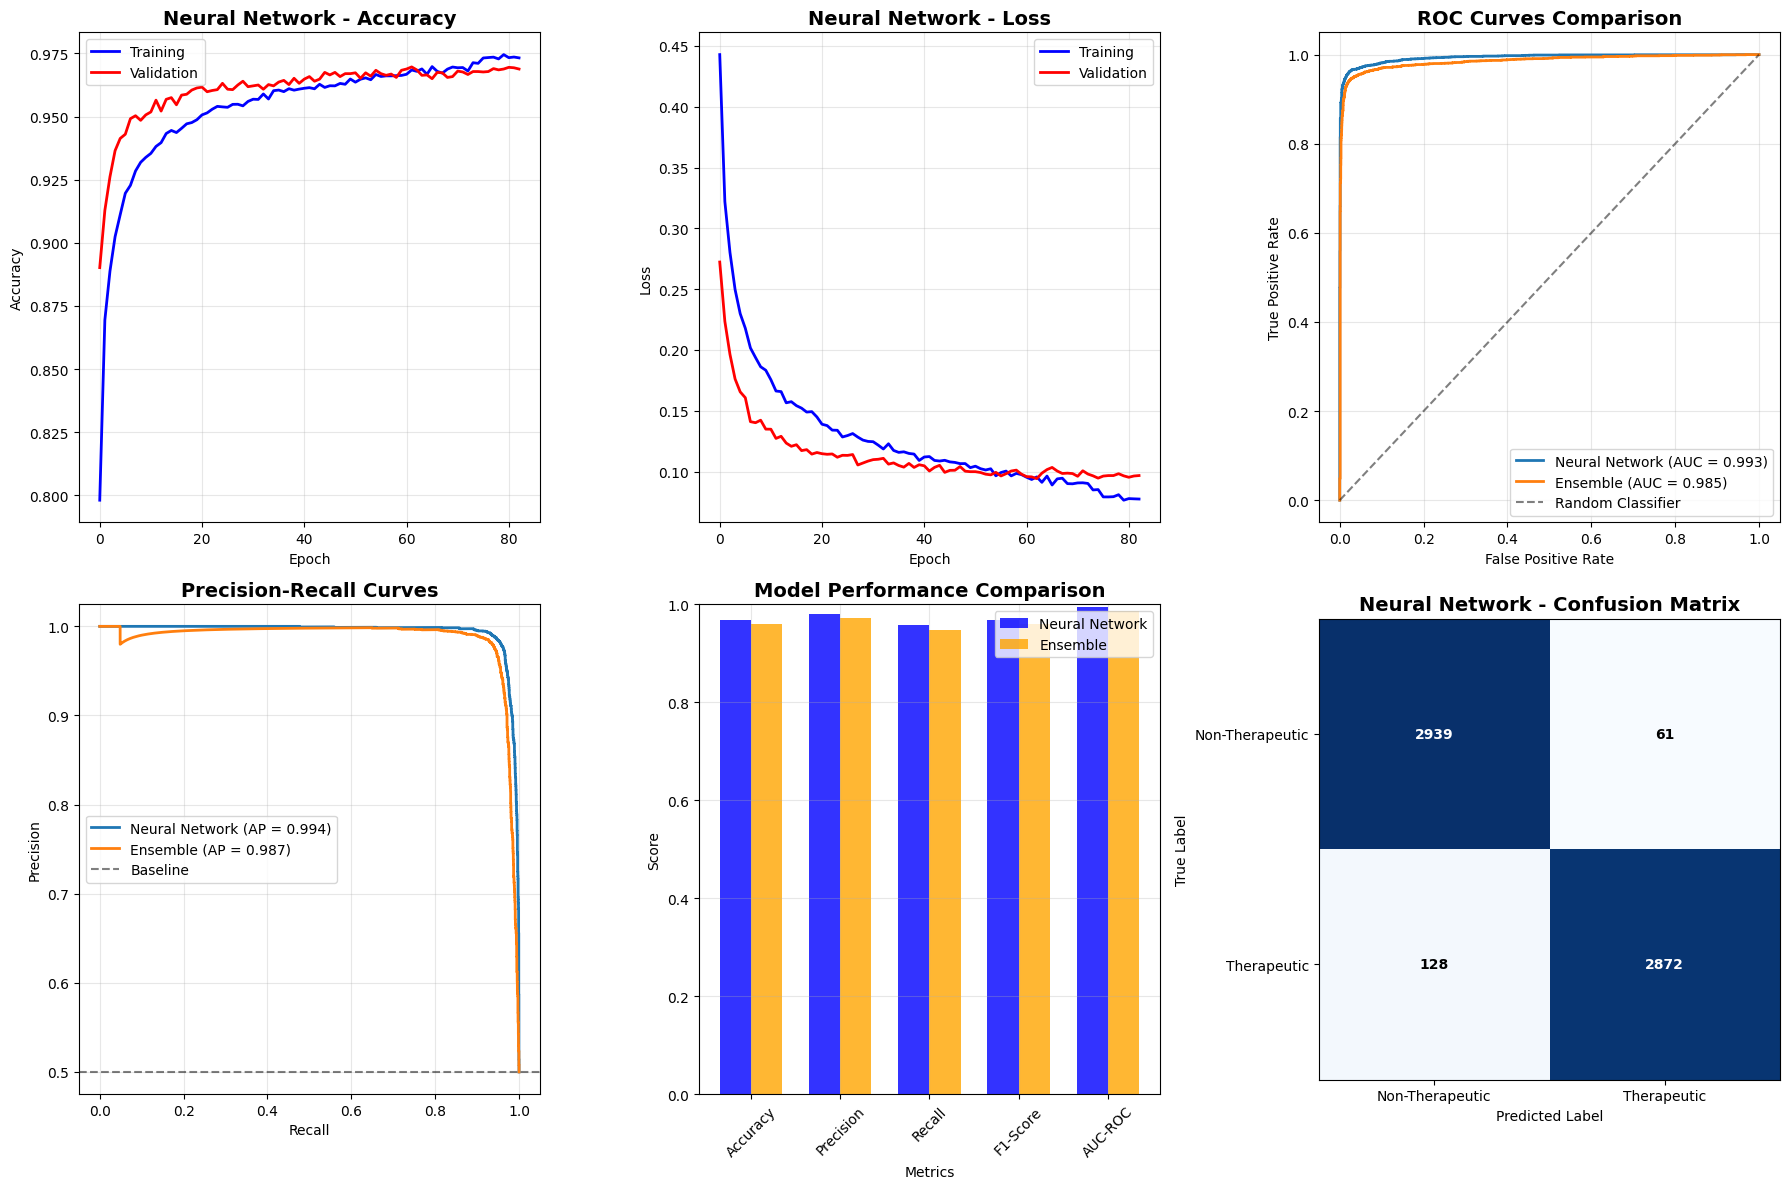

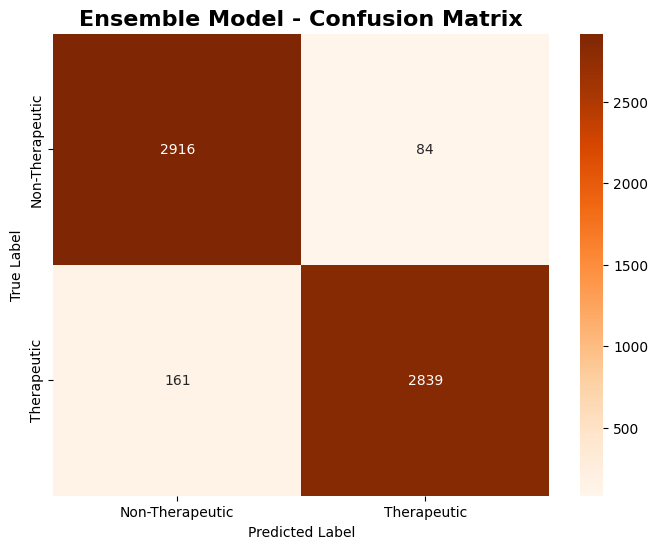


🏆 BINARY CLASSIFICATION PERFORMANCE SUMMARY
Model                Accuracy   Precision  Recall     F1-Score   AUC-ROC    AUC-PR    
----------------------------------------------------------------------------------------------------
Neural Network       0.9685     0.9792     0.9573     0.9681     0.9932     0.9944    
Ensemble             0.9592     0.9713     0.9463     0.9586     0.9851     0.9865    

🥇 Best performing model: Neural Network (F1-Score: 0.9681)

✅ Binary classification completed!
📁 Models saved:
  - Neural Network: ../backend/models/advanced_binary_classifier.h5
  - Ensemble: ../backend/models/ensemble_binary_classifier.pkl
  - Scaler: ../backend/models/binary_classification_scaler.pkl
🔬 Feature extraction method: Custom biochemical features


In [3]:
# Train advanced neural network model
print("\n🏗️ Building Advanced Binary Classification Model...")
nn_model = create_advanced_binary_classifier(features_scaled.shape[1])
nn_model.summary()

# Ensure y_train and y_test are numpy arrays to avoid Keras ValueError
y_train = np.array(y_train)
y_test = np.array(y_test)

# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=20, 
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        '../backend/models/advanced_binary_classifier.h5', 
        save_best_only=True, 
        monitor='val_loss',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=10, 
        min_lr=1e-6,
        verbose=1
    )
]

print("\n🚀 Training Neural Network...")
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate neural network
print("\n📊 Evaluating Neural Network...")
nn_results = nn_model.evaluate(X_test, y_test, verbose=0)
nn_loss, nn_acc, nn_precision, nn_recall, nn_auc = nn_results

y_pred_proba_nn = nn_model.predict(X_test, verbose=0)
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int).flatten()

nn_f1 = f1_score(y_test, y_pred_nn)
nn_ap = average_precision_score(y_test, y_pred_proba_nn)

print(f"Neural Network Results:")
print(f"  Accuracy: {nn_acc:.4f}")
print(f"  Precision: {nn_precision:.4f}")
print(f"  Recall: {nn_recall:.4f}")
print(f"  F1-Score: {nn_f1:.4f}")
print(f"  AUC-ROC: {nn_auc:.4f}")
print(f"  AUC-PR: {nn_ap:.4f}")

# Train ensemble voting classifier
print("\n🤝 Training Ensemble Voting Classifier...")
ensemble_model = create_ensemble_voting_classifier(X_train, y_train)
ensemble_model.fit(X_train, y_train)

# Evaluate ensemble
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test)[:, 1]
y_pred_ensemble = ensemble_model.predict(X_test)

ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble)
ensemble_recall = recall_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble)
ensemble_auc = roc_auc_score(y_test, y_pred_proba_ensemble)
ensemble_ap = average_precision_score(y_test, y_pred_proba_ensemble)

print(f"Ensemble Results:")
print(f"  Accuracy: {ensemble_acc:.4f}")
print(f"  Precision: {ensemble_precision:.4f}")
print(f"  Recall: {ensemble_recall:.4f}")
print(f"  F1-Score: {ensemble_f1:.4f}")
print(f"  AUC-ROC: {ensemble_auc:.4f}")
print(f"  AUC-PR: {ensemble_ap:.4f}")

# Save ensemble model
with open("../backend/models/ensemble_binary_classifier.pkl", "wb") as f:
    pickle.dump(ensemble_model, f)

# Cross-validation for robust evaluation
print("\n🔄 Performing 5-Fold Cross-Validation on Ensemble...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ensemble_model, features_scaled, labels, cv=skf, scoring='f1')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Detailed classification reports
print("\n" + "="*80)
print("NEURAL NETWORK CLASSIFICATION REPORT:")
print("="*80)
print(classification_report(y_test, y_pred_nn, target_names=['Non-Therapeutic', 'Therapeutic']))

print("\n" + "="*80)
print("ENSEMBLE CLASSIFICATION REPORT:")
print("="*80)
print(classification_report(y_test, y_pred_ensemble, target_names=['Non-Therapeutic', 'Therapeutic']))

# Enhanced visualization
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training History - Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2, color='blue')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, color='red')
axes[0, 0].set_title('Neural Network - Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Training History - Loss
axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2, color='blue')
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2, color='red')
axes[0, 1].set_title('Neural Network - Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. ROC Curves Comparison
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_pred_proba_ensemble)

axes[0, 2].plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_auc:.3f})', linewidth=2)
axes[0, 2].plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble (AUC = {ensemble_auc:.3f})', linewidth=2)
axes[0, 2].plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
axes[0, 2].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Precision-Recall Curves
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_pred_proba_nn)
precision_ensemble, recall_ensemble, _ = precision_recall_curve(y_test, y_pred_proba_ensemble)

axes[1, 0].plot(recall_nn, precision_nn, label=f'Neural Network (AP = {nn_ap:.3f})', linewidth=2)
axes[1, 0].plot(recall_ensemble, precision_ensemble, label=f'Ensemble (AP = {ensemble_ap:.3f})', linewidth=2)
axes[1, 0].axhline(y=sum(y_test)/len(y_test), color='k', linestyle='--', alpha=0.5, label='Baseline')
axes[1, 0].set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Model Performance Comparison
models = ['Neural Network', 'Ensemble']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
nn_values = [nn_acc, nn_precision, nn_recall, nn_f1, nn_auc]
ensemble_values = [ensemble_acc, ensemble_precision, ensemble_recall, ensemble_f1, ensemble_auc]

x_pos = np.arange(len(metrics))
width = 0.35

axes[1, 1].bar(x_pos - width/2, nn_values, width, label='Neural Network', alpha=0.8, color='blue')
axes[1, 1].bar(x_pos + width/2, ensemble_values, width, label='Ensemble', alpha=0.8, color='orange')
axes[1, 1].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics, rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1)

# 6. Confusion Matrices
cm_nn = confusion_matrix(y_test, y_pred_nn)
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)

# Neural Network Confusion Matrix
im1 = axes[1, 2].imshow(cm_nn, interpolation='nearest', cmap='Blues')
axes[1, 2].set_title('Neural Network - Confusion Matrix', fontsize=14, fontweight='bold')
tick_marks = np.arange(2)
axes[1, 2].set_xticks(tick_marks)
axes[1, 2].set_yticks(tick_marks)
axes[1, 2].set_xticklabels(['Non-Therapeutic', 'Therapeutic'])
axes[1, 2].set_yticklabels(['Non-Therapeutic', 'Therapeutic'])
axes[1, 2].set_ylabel('True Label')
axes[1, 2].set_xlabel('Predicted Label')

# Add text annotations
thresh = cm_nn.max() / 2
for i, j in np.ndindex(cm_nn.shape):
    axes[1, 2].text(j, i, format(cm_nn[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm_nn[i, j] > thresh else "black",
                   fontweight='bold')

plt.tight_layout()
plt.show()

# Separate figure for ensemble confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Non-Therapeutic', 'Therapeutic'],
            yticklabels=['Non-Therapeutic', 'Therapeutic'])
plt.title('Ensemble Model - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Performance summary
print("\n" + "="*100)
print("🏆 BINARY CLASSIFICATION PERFORMANCE SUMMARY")
print("="*100)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC-ROC':<10} {'AUC-PR':<10}")
print("-"*100)
print(f"{'Neural Network':<20} {nn_acc:<10.4f} {nn_precision:<10.4f} {nn_recall:<10.4f} {nn_f1:<10.4f} {nn_auc:<10.4f} {nn_ap:<10.4f}")
print(f"{'Ensemble':<20} {ensemble_acc:<10.4f} {ensemble_precision:<10.4f} {ensemble_recall:<10.4f} {ensemble_f1:<10.4f} {ensemble_auc:<10.4f} {ensemble_ap:<10.4f}")

# Determine best model
if ensemble_f1 > nn_f1:
    best_model = "Ensemble"
    best_f1 = ensemble_f1
else:
    best_model = "Neural Network"
    best_f1 = nn_f1

print(f"\n🥇 Best performing model: {best_model} (F1-Score: {best_f1:.4f})")

print("\n✅ Binary classification completed!")
print("📁 Models saved:")
print("  - Neural Network: ../backend/models/advanced_binary_classifier.h5")
print("  - Ensemble: ../backend/models/ensemble_binary_classifier.pkl")
print("  - Scaler: ../backend/models/binary_classification_scaler.pkl")
print(f"🔬 Feature extraction method: {'ProtBERT embeddings' if use_protbert else 'Custom biochemical features'}")